# DivNoising - Prediction
This notebook contains an example on how to use a previously trained DivNoising VAE to denoise images.
If you haven't done so please first run ```0-CreateNoiseModel.ipynb``` and ```1-Training.ipynb```, which will download the data, create a noise model and train the DivNoising model.  

In [19]:
# We import all our dependencies.
import numpy as np
import torch
import time
import sys
sys.path.append('../../')
from divnoising import utils
from nets import lightningmodel
from glob import glob
from tifffile import imread
from matplotlib import pyplot as plt
from divnoising import utils
device = torch.cuda.current_device()

# Load data to predict on
The data should be present in the directory specified by ```noisy_data_path``` and the ```noisy_input``` is the name of the image in this directory that needs to be denoised. 
This notebook expects 2D datasets in ```.tif``` format. If your data is a stack of 2D images, you can load it as shown in the next cell. If you dataset has multiple individual 2D tif files, comment out the second line in the cell below and uncomment the third line.

In [20]:
noisy_data_path="../../data/Mouse_skull_nuclei/"
noisy_input= imread(noisy_data_path+'example2_digital_offset300.tif') 
# noisy_input= imread(noisy_data_path+'*.tif').astype(np.float32) # To load multiple individual 2D tif images

In [21]:
from divnoising import utils 
x_train_crops = utils.extract_patches(noisy_input, patch_size=512, num_patches=8)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 254.98it/s]


# Load our model
We load the last weights of the trained model from the ```basedir```. The ```basedir``` should be the same which you specified in the training notebook `1-Training.ipynb`. Also specify the ```model_name```. It should be the same as specified in the training notebook `1-Training.ipynb`. 

In [22]:
%%capture
basedir = 'models'
model_name = 'divnoising_mouse_skull_nuclei_demo'

name = glob(basedir+"/"+model_name+'_last.ckpt')[0]
vae = lightningmodel.VAELightning.load_from_checkpoint(checkpoint_path = name)
if not torch.cuda.is_available():
    raise ValueError("GPU not found, predictions will run on CPU and can be somewhat slow!")
else:
    vae.to(device)

# Here we predict some qulitative diverse solutions

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 335.56it/s]


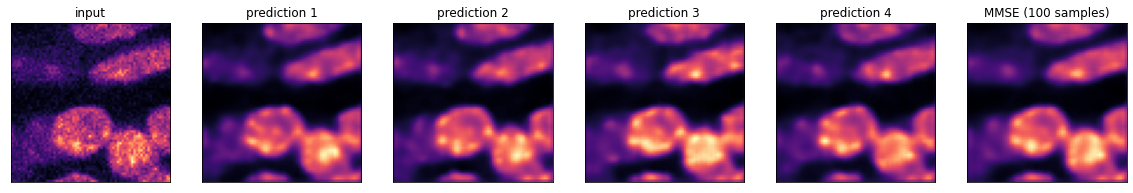

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 797.56it/s]


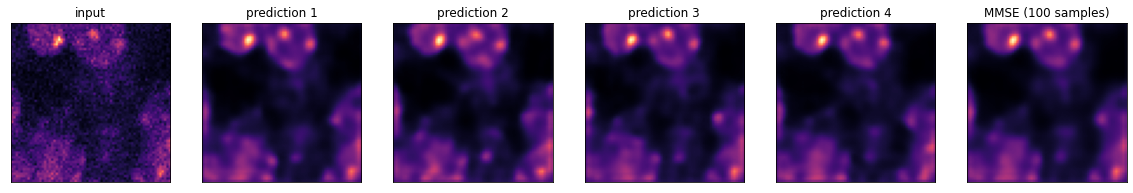

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 712.35it/s]


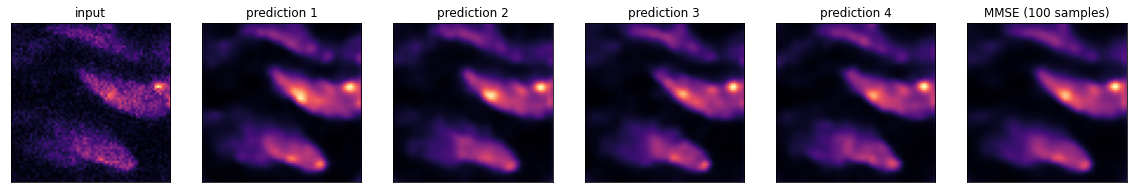

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 797.89it/s]


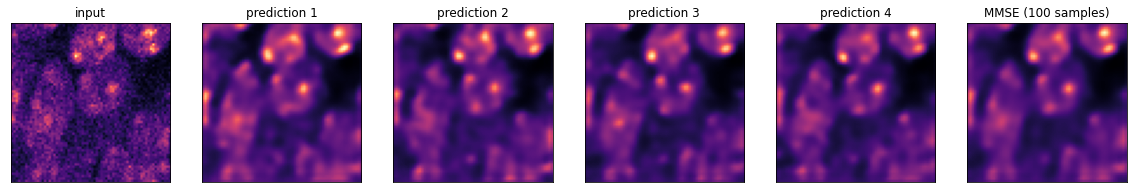

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 709.44it/s]


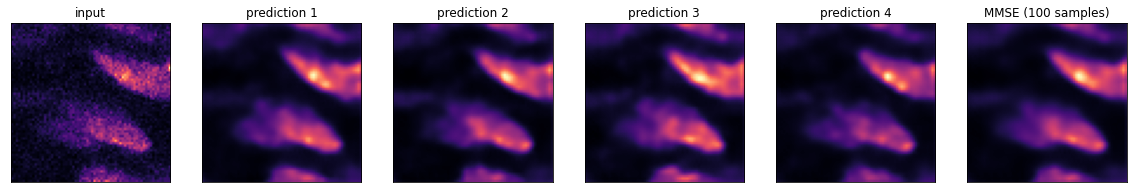

In [23]:
utils.plot_qualitative_results(x_train_crops,vae,device)

# Predict denoised images and (optionally) save them
Specify how many denoised samples need to be predicted for each noisy image by specifying the parameter ```num_samples```. Also MMSE denoised estimate will be computed using these many samples.  

If you do not want access to different samples but just need the MMSE denoised estimate, set the paarmeter ```returnSamples=False```.

You can also save the denoised results (both samples and MMSE estimate for each noisy image) by providing the ```export_results_path``` which is the directory where the results should be saved.

Alternatively, you can also export the MMSE estimate and only a fraction of the samples used for computing MMSE estimate for each image by specifying the parameter ```fraction_sample_to_export```. If set to $0$, none of the samples are exported and only the MMSE estimate is exported, whereas setting it to $1$ exports all samples used for computing MMSE estimate.

If you only want to export MMSE estimate, set parameter ```export_mmse``` to True. If you do not want to export MMSE estimate, set it to ```False```.

The parameter ```tta``` refers to test time augmentation which may improve performance of DivNoising even further but will take ```8x``` longer to predict. This is enabled by default. If you wish to disable it, set it to ```False```.

In [24]:
len(x_train_crops)

1600

In [25]:
x_train_crops.shape

(1600, 512, 512)

In [26]:
num_samples = 10
export_results_path = "denoised_results"
fraction_samples_to_export = 1
export_mmse = True
tta = True
mmse_results = utils.predict_and_save(x_train_crops,vae,num_samples,device,
                                fraction_samples_to_export,export_mmse,export_results_path,tta)

Processing image: 0


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 57.93it/s]


# Compute PSNR
Here we compute Peak Signal-to-Noise Ratio (PSNR) of the denoised MMSE output with respect to the available GT data specified by the ```gt``` parameter in the next cell. If you do not have GT data, do not run this cell.

In [30]:
len(mmse_results)

1

In [27]:
PSNRs=[]
gt=np.mean(noisy_input[:,...],axis=0)[np.newaxis,...]

for i in range(len(mmse_results)):
    psnr=utils.PSNR(gt[0],mmse_results[i])
    PSNRs.append(psnr)
    print("image:", i, "psnr:"+format(psnr,".3f")+ "\t mean psnr:"+format(np.mean(PSNRs),".3f")) 
    time.sleep(0.5)
    
print('mean',np.mean(PSNRs))

image: 0 psnr:34.917	 mean psnr:34.917
mean 34.916789801272245
